# Steps to Fit the Data
Here, we show how we arrived at the model, in particular what we looked at to remove the useless features etc.

We start with the usual imports for ipython notebooks.

In [1]:
# Useful starting lines
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
%load_ext autoreload
%autoreload 2

# Load data

In [2]:
from helpers import *
from model_learning import *
from build_polynomial import build_poly
import datetime

In [3]:
filename = 'train.csv'
prediction, x_raw, ids = load_csv_data(filename, sub_sample=False)

# Data Exploration

We first look at the number of NA values per data record (i.e. per row).

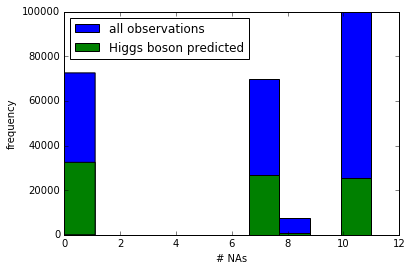

In [4]:
# get the na count per row
naCountPerRow = np.sum(x_raw == -999, axis=1)
naCountPerRowWithPred = naCountPerRow[prediction == 1] # where higgs boson was predicted
f = plt.figure()
plt.hist(naCountPerRow, label='all observations')
plt.hist(naCountPerRowWithPred, label='Higgs boson predicted')
plt.legend(loc='best')
plt.xlabel('# NAs')
plt.ylabel('frequency')
plt.show()
f.savefig('Images/NAPerRow.pdf')

In [5]:
! ls Images

feature_correlations.pdf  NAPerColumn.pdf  NAPerRow.pdf


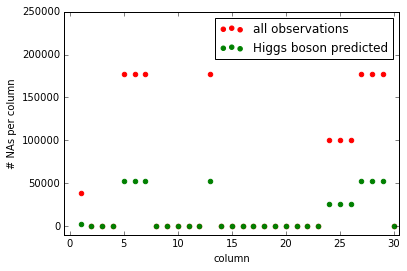

array([ 38114,      0,      0,      0, 177457, 177457, 177457,      0,
            0,      0,      0,      0, 177457,      0,      0,      0,
            0,      0,      0,      0,      0,      0,      0,  99913,
        99913,  99913, 177457, 177457, 177457,      0])

In [6]:
# get the na count per column
naCountPerColumn = np.sum(x_raw == -999, axis=0)
naCountPerColumnWithPred = np.sum(x_raw[prediction==1,:] == -999, axis=0) # where higgs boson was predicted
nbColumns = x_raw.shape[1]
rowNumbers = np.arange(1, nbColumns + 1)

f = plt.figure()
plt.scatter(rowNumbers, naCountPerColumn, label='all observations', color='r')
plt.scatter(rowNumbers, naCountPerColumnWithPred, label='Higgs boson predicted', color='g')
plt.xlim(xmin=-0.5, xmax=nbColumns+0.5)
plt.ylim(ymin=-10000, ymax = 250000)
plt.legend(loc='best')
#plt.legend(bbox_to_anchor=(1.6, 0.5))
plt.xlabel('column')
plt.ylabel('# NAs per column')
plt.show()
f.savefig('Images/NAPerColumn.pdf')

naCountPerColumn

We store the columns that we want to ignore in 'manyNaNsColumns'.

In [7]:
manyNaNsColumns = np.where(naCountPerColumn > 150000)
#manyNaNsColumns = [4,5,6,12, ]
naCountPerColumn[manyNaNsColumns]

array([177457, 177457, 177457, 177457, 177457, 177457, 177457])

In [8]:
# replace missing values in each column with median value in this column
def interpolate_with_median(x_raw):
    medians_xraw = np.median(x_raw, axis=0)
    x_proc = x_raw

    for col_index in range(x_raw.shape[1]):
        x_proc[x_raw[:, col_index] == -999, col_index] = medians_xraw[col_index]
        
    return x_proc

# remove unwanted features
def remove_features(x, featuresToIgnore):
    
    if featuresToIgnore is None:
        x_proc = x
    else:
        x_proc = np.delete(x, featuresToIgnore, axis=1)
    
    return x_proc

#
def clean_data_and_standardize(x_raw, varianceToKeep, toPCABasis_fcn, featuresToIgnore, 
                               mean_x=None, std_x=None):
    """
    toPCABasis_fcn is a function that returns the data after PCA dimensional reduction
    """
    
    x_proc = interpolate_with_median(x_raw)
    
    x_proc = remove_features(x_proc, featuresToIgnore)
    
    if varianceToKeep is not None:
        if toPCABasis_fcn is not None:
            print("Error: PCA basis should not be given - ignoring")
        toPCABasis_fcn = pca(x_proc, varianceToKeep = varianceToKeep)
    else:
        if (toPCABasis_fcn is None) or (mean_x is None) or (std_x is None):
            print("Error: should specify PCA basis, mean and std of data (used to transform training.csv)")
    
    x_proc = toPCABasis_fcn(x_proc)
    
    tx, mean_x, std_x = standardize(x_proc, mean_x, std_x)
    
    return (tx, mean_x, std_x, toPCABasis_fcn)

def pca(data, varianceToKeep):
    """ varianceToKeep is the maximum fraction of the variance we want to keep, it can be at most 1
    varianceToKeep = 1 means we don't reduce the number of features
    returns a function to convert features to reduced features
    
    Implementation follows the mathematical explanation from
    https://en.wikipedia.org/wiki/Principal_component_analysis
    """
    
    # make data have mean 0
    data_mean = np.mean(data, axis=0)
        
    X = data - data_mean
    covar = X.T @ X
    # find largest eigenvalues, svd does this
    u, s, v = np.linalg.svd(covar)
    retained_variance = np.cumsum(s) / np.sum(s)
    new_PCA_basis = u[:, retained_variance <= varianceToKeep]
    
    # apply this function to X
    convertToPCA = lambda X1 : (X1 - data_mean) @ new_PCA_basis
    return convertToPCA
    
    

Check that PCA is well reducing the number of features.

In [9]:
(tx, mean_x, std_x, toPCABasis_fcn) = clean_data_and_standardize(
    x_raw, varianceToKeep=0.999, toPCABasis_fcn=None, featuresToIgnore=manyNaNsColumns)

print(x_raw.shape)
print(tx.shape)

(250000, 30)
(250000, 10)


Get the number of reduced features with PCA as a function of the maximum retained variance.

In [10]:
print(x_raw.shape)

for variance in [0.2, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 0.99, 0.999, 0.9999, 0.99999, 1]:
    (tx, mean_x, std_x, toPCABasis_fcn) = clean_data_and_standardize(
    x_raw, varianceToKeep=variance, toPCABasis_fcn=None, featuresToIgnore=manyNaNsColumns)
    
    #transf_data, new_base = pca(x_proc, varianceToKeep = variance)
    #transf_data_raw, new_base_raw = pca(x_raw, varianceToKeep = variance)

    print("{}: proc: {}".format(variance, tx.shape))
    

(250000, 30)
0.2: proc: (250000, 0)
0.4: proc: (250000, 0)
0.5: proc: (250000, 0)
0.6: proc: (250000, 0)
0.7: proc: (250000, 0)
0.8: proc: (250000, 1)
0.9: proc: (250000, 2)
0.99: proc: (250000, 8)
0.999: proc: (250000, 10)
0.9999: proc: (250000, 15)
0.99999: proc: (250000, 18)
1: proc: (250000, 22)


We choose the variance to keep to be 0.999 (to avoid having many features). We choose it here because the algorithm will otherwise be too computationally expensive (since later on, we also allow cross-features and this gives a much better agreement than just taking polynomial features).

In [11]:
(tx, mean_x, std_x, toPCABasis_fcn) = clean_data_and_standardize(
    x_raw, varianceToKeep=0.9999, toPCABasis_fcn=None, featuresToIgnore=manyNaNsColumns)

Check that data looks nice, i.e. has no obvious bad patterns for each feature.

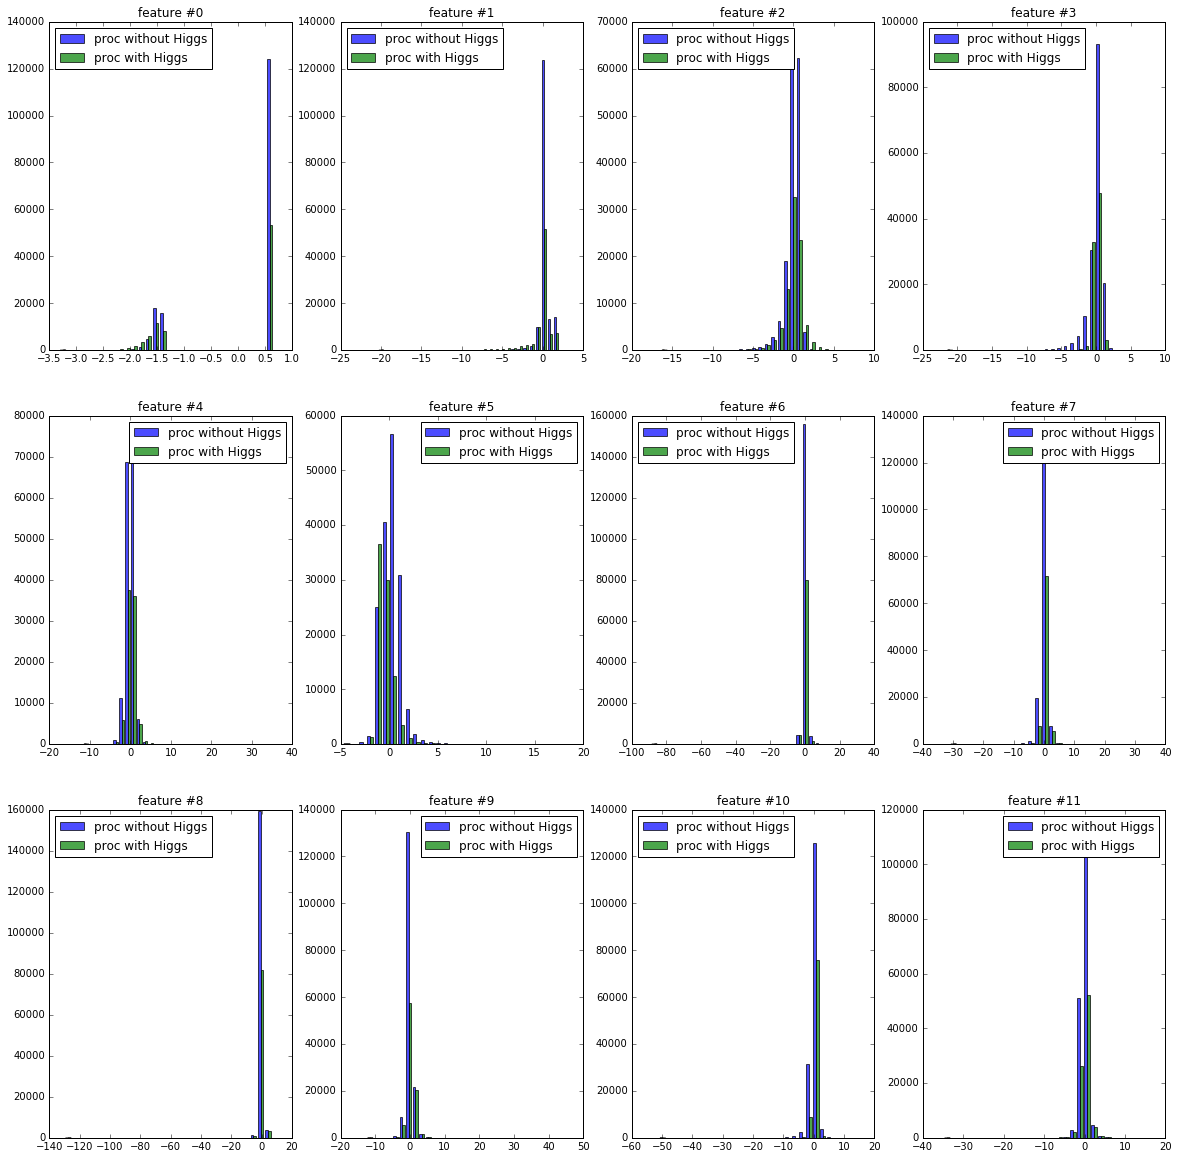

In [215]:
# plot histogram of features

def plotFeatureDistribution(proc_data, filename):
    
    nbFeatures = proc_data.shape[1]
    nbCols = 4
    nbRows = int(np.ceil(nbFeatures / nbCols))
    f, ax = plt.subplots(nbRows, nbCols, figsize=(20,20))
    for col_index in range(nbFeatures):
        ax_spec = ax[col_index // nbCols, col_index % nbCols]
        ax_spec.hist(
                [proc_data[prediction==-1, col_index], proc_data[prediction==1, col_index]], label=['proc without Higgs', 'proc with Higgs'], alpha=0.7, bins=30)
        ax_spec.legend(loc='best')
        ax_spec.set_title("feature #{}".format(col_index))
        #break
    #f.show()
    

#tx[:,0] = np.log(tx[:,0])
plotFeatureDistribution(tx, 'Images/FeatureDistribution_Processed.pdf')

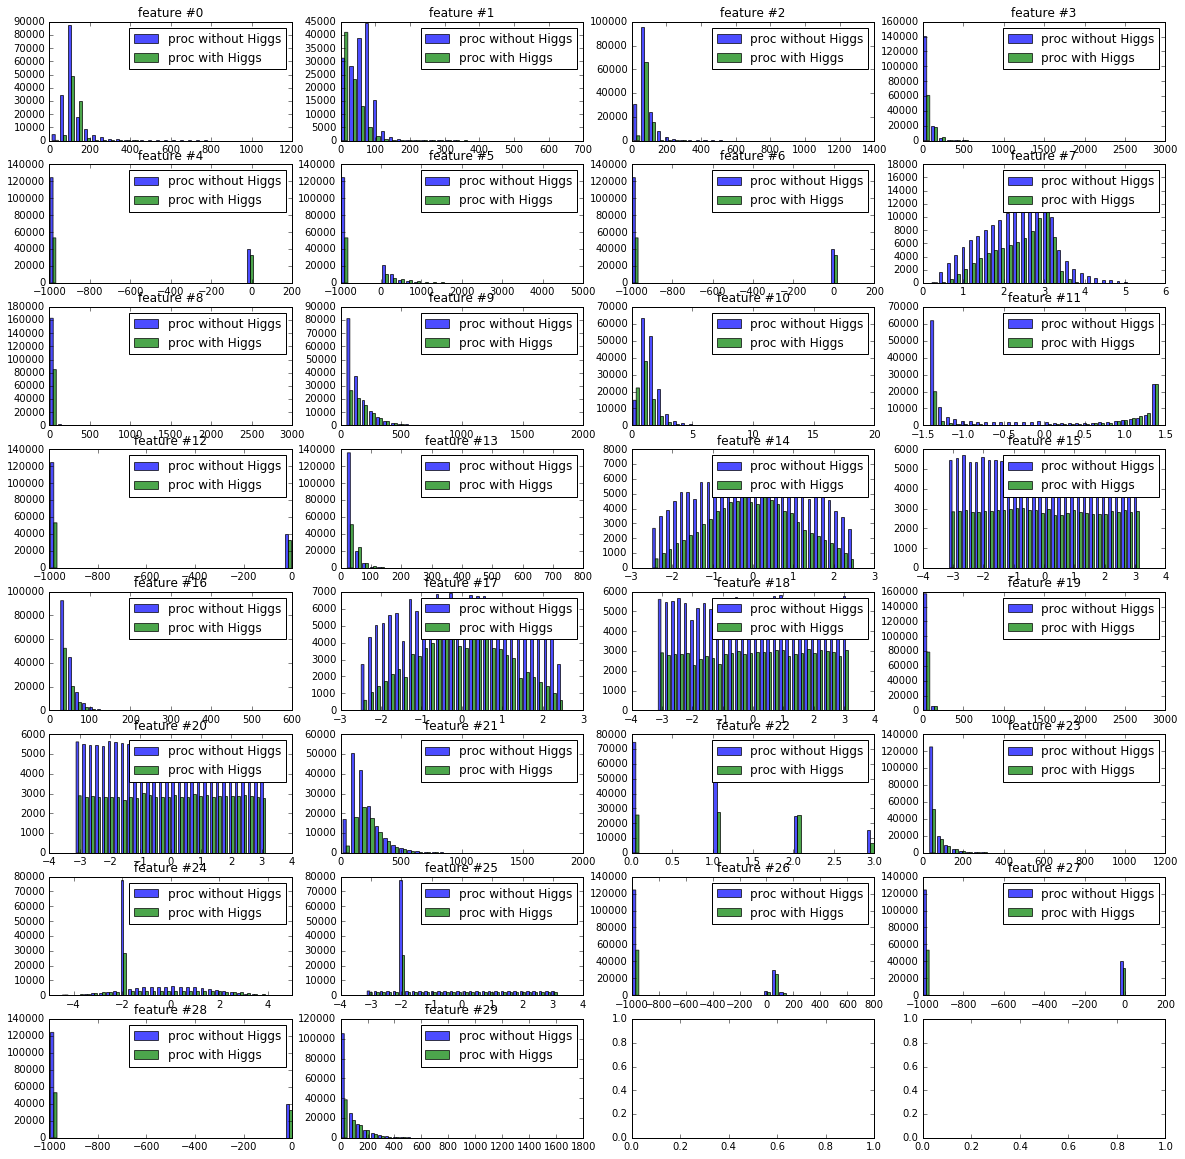

In [216]:
plotFeatureDistribution(x_raw, 'Images/FeatureDistribution_Raw.pdf')

Also check cross-relation between each pair of features. We don't use it here, but previous analysis showed that PCA works better than manually extracting by eye.

feature #0
feature #1
feature #2
feature #3
feature #4
feature #5
feature #6
feature #7
feature #8
feature #9


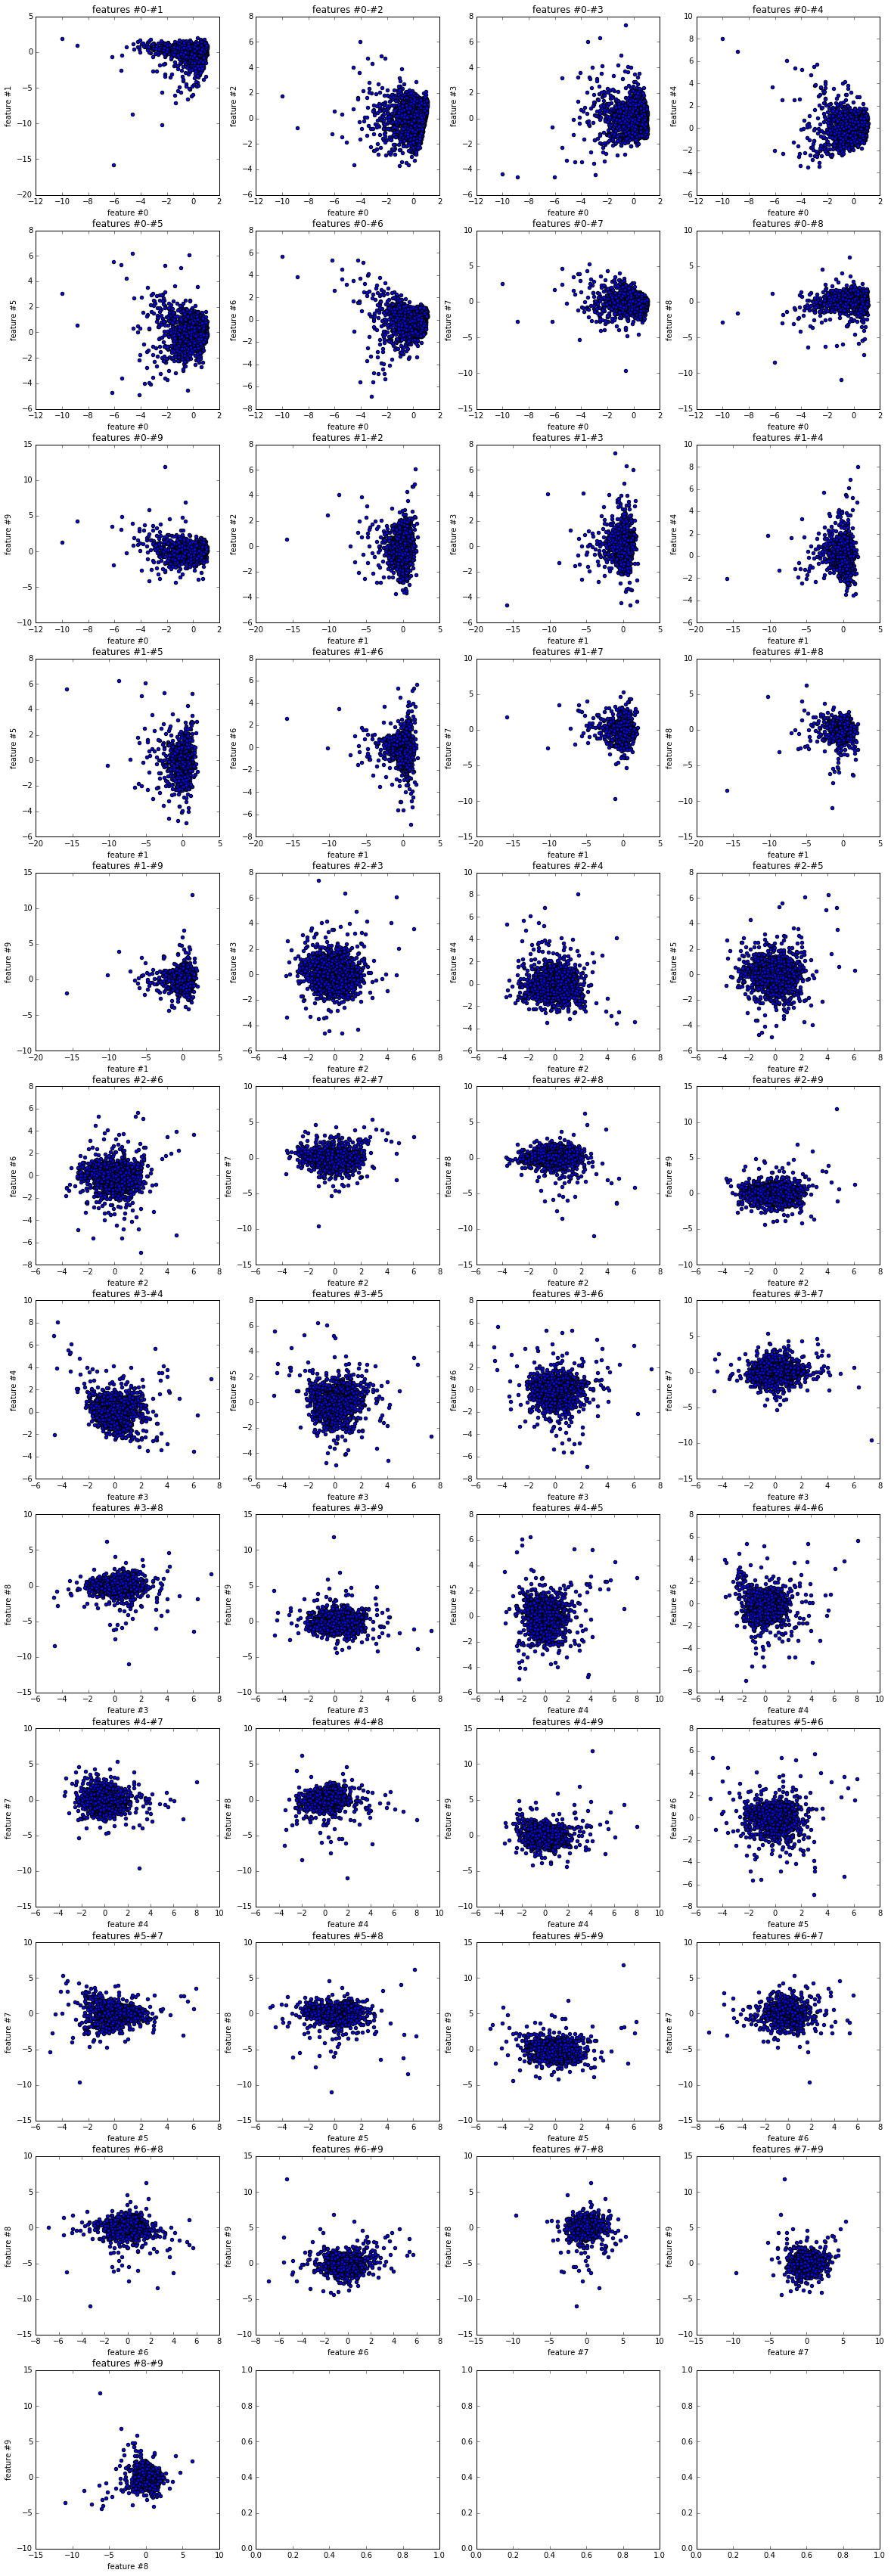

In [125]:
# to reduce plotting time
def sample_data(x, seed, size_samples):
    """sample from dataset."""
    np.random.seed(seed)
    num_observations = x.shape[0]
    random_permuted_indices = np.random.permutation(num_observations)
    #y = y[random_permuted_indices]
    x = x[random_permuted_indices[:size_samples]]
    return x#x[:size_samples] #y[:size_samples], 

# run it only if you have time (approx. 30 seconds), replace 0 below
def plotFeatureCorrelations(data, nbFeaturesToCompare=None):
    
    if nbFeaturesToCompare is None:
        nbFeatures = data.shape[1]
    nbCols = 4
    nbRows = max(int(np.ceil((nbFeatures * (nbFeatures-1))/2 / nbCols)), 1)
    f, ax = plt.subplots(nbRows, nbCols, figsize=(20, 5 * nbRows))
    plotIndex = 0
    for feat1 in range(nbFeatures):
        print("feature #{}".format(feat1))
        for feat2 in range(feat1+1, nbFeatures):

            ax_spec = ax[plotIndex // nbCols, plotIndex % nbCols]
            ax_spec.scatter(data[:, feat1], data[:, feat2])
            #ax_spec.legend(loc='best')
            ax_spec.set_xlabel('feature #{}'.format(feat1))
            ax_spec.set_ylabel('feature #{}'.format(feat2))
            ax_spec.set_title("features #{}-#{}".format(feat1, feat2))

            plotIndex = plotIndex + 1
        
    f.savefig('Images/feature_correlations.pdf')
    
    
# sampled data to reduce plotting time
sampled_tx = sample_data(tx, seed=None, size_samples=2000)
plotFeatureCorrelations(sampled_tx)

# We could also repeat this on the unprocessed data

# Predict Weights with Gradient Descent

We test the weight finding methods we implemented here.

In [12]:
varianceToKeep = 0.9999
naCountPerColumn = np.sum(x_raw == -999, axis=0)
manyNaNsColumns = np.where(naCountPerColumn > 150000)

(tx, mean_x, std_x, toPCABasis_fcn) = clean_data_and_standardize(
    x_raw, varianceToKeep=varianceToKeep, toPCABasis_fcn=None, featuresToIgnore=manyNaNsColumns)

print(tx.shape)
print(len(prediction))

(250000, 15)
250000


Check that the implemented methods work well.

In [68]:
from implementations import *

nbFeatures = tx.shape[1]
max_iters = 2500
gamma = 0.001
batch_size = 1
initial_w = np.array([10] * nbFeatures)
lamb = 1

testMethod = 'Ridge_GD'

if testMethod == 'GD':
    w = least_squares_GD(prediction, tx, initial_w, max_iters, gamma, lambda_=lamb)
elif testMethod == 'SGD':
    batch_size = 1
    w = least_squares_SGD(prediction, tx, initial_w, max_iters, gamma, batch_size=batch_size, lambda_=lamb, min_loss_threshold = 0)
elif testMethod == 'Ridge_SGD':
    # logistic with SGC does not work very well, maybe it is because of the parameters
    batch_size=10
    gamma = 0.005
    w = reg_logistic_regression_with_SGD(prediction, tx, lambda_=lamb, initial_w=initial_w, max_iters=max_iters, gamma=gamma)
elif testMethod == 'Ridge_GD':
    gamma = 0.0001
    w = reg_logistic_regression(prediction, tx, lambda_=lamb, initial_w=initial_w, max_iters=max_iters, gamma=gamma)

Gradient Descent(0/2499): changeInLoss=1432647.6460666307, loss=2806561.1355376407, w0=6.02371920294804, w1=8.17129715159923


KeyboardInterrupt: 

# Do Cross Validation

In [291]:
(tx, mean_x, std_x, toPCABasis_fcn) = clean_data_and_standardize(
    x_raw, varianceToKeep=varianceToKeep, toPCABasis_fcn=None, featuresToIgnore=None)

We have to use exact equations (normal equations) because we could not find any parameters for the (S)GD that lead to convergence for all degrees.

In [79]:
from build_polynomial import *

def find_best_parameters_model(y, tx, ratio_train, seeds, degrees, cross_features_degree, lambdas, k_fold):
    """ does the cross-validation and finds the model with the best results 
    for logistic regression
    """
    
    nbFeaturesRaw = tx.shape[1]
    # for build_poly cross features
    computeMaskForCrossFeatureDegree(cross_features_degree, nbFeaturesRaw)
    
    
    # for logistic regression iteration
    max_iters = 2500
    gamma = 0.001
    min_loss_threshold = 10e-3
    batch_size = 20
    
    

    # define list to store the variable
    rmse_tr = np.empty((len(seeds), len(degrees)))
    rmse_te = np.empty((len(seeds), len(degrees)))
    fraction_tr_val = np.empty((len(seeds), len(degrees)))
    fraction_te_val = np.empty((len(seeds), len(degrees)))
    
    for index_seed, seed in enumerate(seeds):
        
        print("Starting with seed #{}".format(index_seed))
        
        # use training set (tx_tr, y_tr) to learn best lambda for given degree
        # with this lambda, then compute the training and testing error on (tx_te, y_te)
        (tx_tr, y_tr, tx_te, y_te) = split_data(tx, y, ratio_train, seed=seed)
        
        for index_degree, degree in enumerate(degrees):
            
            # logistic regression
            #compute_weights_function = lambda y, tx, lambda_, initial_w: reg_logistic_regression(
            #    y, tx, lambda_, initial_w, max_iters, gamma, min_loss_threshold=min_loss_threshold)
            #compute_loss_function = lambda y, tx, w, lambda_: compute_loss_logistic_regression(
            #    y, tx, w, lambda_)
            
            # linear regression using SGD
            compute_weights_function = lambda y, tx, lambda_, initial_w: least_squares_SGD(
                y, tx, initial_w, max_iters, gamma, batch_size=batch_size, lambda_=lambda_, min_loss_threshold=min_loss_threshold)
            compute_loss_function = lambda y, tx, w, lambda_: compute_loss_least_squares(
                y, tx, w, lambda_)
            
            # linear regression using exact equations
            compute_weights_function = lambda y, tx, lambda_, initial_w: ridge_regression(y, tx, lambda_)
            compute_loss_function = lambda y, tx, w, lambda_: compute_loss_least_squares(
                y, tx, w, lambda_)
            
            
            lambda_error_te = np.empty((len(lambdas)))
            for i, lambda_ in enumerate(lambdas):
                print("Taking degree {}, lambda {}".format(degree, lambda_))
                                
                (train_error, test_error, fraction_correct_tr, fraction_correct_te) = k_cross_validation(
                    y_tr, tx_tr, degree, cross_features_degree, lambda_, k_fold, seed,
                    compute_weights_function, compute_loss_function)
                lambda_error_te[i] = test_error
                
            bestLambdaIndex = np.argmin(lambda_error_te)
            bestLambda = lambda_error_te[bestLambdaIndex]
            print("Best lambda for degree {}: {} (index {})".format(degree, bestLambda, bestLambdaIndex))
    
            
            # for this lambda, now compute the testing error on the test set
            
            # add polynomial features
            tx_poly_tr = build_poly(tx_tr, degree, cross_features_degree)
            tx_poly_te = build_poly(tx_te, degree, cross_features_degree)
    
            # compute weights with ridge_regression on training set with given lambda (and degree)
            nbFeatures = tx_poly_tr.shape[1]
            initial_w = [10] * nbFeatures
            weights_tr = compute_weights_function(y_tr, tx_poly_tr, lambda_ = bestLambda, initial_w=initial_w)
            
            # find the training and testing error
            mse_tr = compute_loss_function(y_tr, tx_poly_tr, weights_tr, lambda_ = bestLambda)
            mse_te = compute_loss_function(y_te, tx_poly_te, weights_tr, lambda_ = bestLambda)
            rmse_tr_val = np.sqrt(2*mse_tr)
            rmse_te_val = np.sqrt(2*mse_te)
            
            fraction_tr_val[index_seed, index_degree] = get_fraction_correct(y_tr, tx_poly_tr, weights_tr)
            fraction_te_val[index_seed, index_degree] = get_fraction_correct(y_te, tx_poly_te, weights_tr)
                    
            rmse_tr[index_seed, index_degree] = rmse_tr_val
            rmse_te[index_seed, index_degree] = rmse_te_val
            
            print(rmse_tr, rmse_te, fraction_te_val, fraction_tr_val)

    
    return (rmse_tr, rmse_te, fraction_tr_val, fraction_te_val)
    
    
    
# define parameters
seeds = range(2)#range(100)
ratio_train = 0.05#0.005 #TODO: change
degrees = [2,4, 6, 8, 10, 12, 14]#range(1, 10)
cross_features_degree = 2
lambdas = np.logspace(-4,2,10)#np.logspace(-4, 2, 30)
k_fold = 5 # used to determine best lambda for given degree (and seed)

find_best_parameters_model(prediction, tx, ratio_train, seeds, degrees, 
                                 cross_features_degree, lambdas, k_fold)

Starting with seed #0
Taking degree 2, lambda 0.0001
Taking degree 2, lambda 0.00046415888336127773
Taking degree 2, lambda 0.002154434690031882
Taking degree 2, lambda 0.01
Taking degree 2, lambda 0.046415888336127774
Taking degree 2, lambda 0.21544346900318823
Taking degree 2, lambda 1.0
Taking degree 2, lambda 4.641588833612772
Taking degree 2, lambda 21.54434690031882
Taking degree 2, lambda 100.0
Best lambda for degree 2: 0.861626458782777 (index 0)
[[  1.16683804  30.67049856  34.81259757  34.83286959  33.96619304
   31.42983085  41.19370924]
 [ 30.82453111  37.40292986  37.38354211  33.107733    45.39183541
   36.05961825  37.51719872]] [[  1.20497906e+000   1.57839239e-315   0.00000000e+000   0.00000000e+000
    0.00000000e+000   0.00000000e+000   0.00000000e+000]
 [  0.00000000e+000   0.00000000e+000   0.00000000e+000   0.00000000e+000
    0.00000000e+000   0.00000000e+000   0.00000000e+000]] [[  7.51317895e-001   5.38313216e-316   0.00000000e+000   0.00000000e+000
    0.00000

(array([[  1.16683804,   1.25203447,   3.0670637 ,  18.25741911,
          33.33169092,  21.94201712,  15.3546742 ],
        [  1.16727108,   1.21541556,   1.98647216,   6.17835671,
          23.81379648,  37.70733005,  31.12839227]]),
 array([[  1.20497906e+00,   9.24987377e+01,   1.08393416e+04,
           7.08888197e+06,   8.30200490e+09,   8.09189152e+12,
           3.95533100e+15],
        [  1.40096097e+00,   1.57104746e+02,   1.76975565e+05,
           6.87577102e+07,   1.13315858e+11,   7.62089913e+12,
           1.06217425e+17]]),
 array([[ 0.74912,  0.78056,  0.78368,  0.79432,  0.77008,  0.68624,
          0.66888],
        [ 0.76112,  0.78768,  0.7936 ,  0.80448,  0.802  ,  0.76224,
          0.72048]]),
 array([[ 0.75131789,  0.78284632,  0.78569263,  0.79361684,  0.77197474,
          0.68866526,  0.67380632],
        [ 0.75532211,  0.78436632,  0.78852211,  0.79626105,  0.79325053,
          0.75536421,  0.71493053]]))

In [239]:
#from plots import gradient_descent_visualization
from costs import *
from model_learning import *
from cross_validation import *
from build_polynomial import computeMaskForCrossFeatureDegree

nbFeatures = tx.shape[1]

# Define the parameters of the algorithm.
max_iters = 500000
gamma = 0.01
# Initialization

max_iters = 2500
gamma = 0.05
batch_size = 1000
degree = 1

max_iters = 2500
gamma = 0.05
batch_size = 50#int(tx.shape[0]/100)
degree = 1
cross_features_degree = 0
w_initial = [10] * nbFeatures


# for build_poly cross features
computeMaskForCrossFeatureDegree(cross_features_degree = cross_features_degree, nbFeatures = nbFeatures)

# Start gradient descent.
start_time = datetime.datetime.now()


compute_weightsFunctionMSE = lambda y, tx, lambdaIgnored: least_squares_weights(
        y, tx, gamma=gamma, max_iters=max_iters, batch_size=batch_size)
#compute_weightsFunctionMSE = lambda y, tx, lambdaIgnored: exact_least_squares_weights(y, tx)
#weights = stochastic_gradient_descent(prediction, tx, w_initial, batch_size=200, max_iters=max_iters, 
#                                      gamma=gamma, compute_gradientFunction=compute_mse_gradient, compute_lossFunction=compute_mse_loss)
compute_weightsFunctionMAE = lambda y, tx, lambdaIgnored: mae_weights(
        y, tx, gamma=gamma, max_iters=max_iters, batch_size=batch_size)

# with MSE loss function
#(rmse_tr, rmse_te) = k_cross_validation(prediction, tx, k_fold=5, lambda_=0, 
#                                        cross_features_degree = cross_features_degree, degree=degree, seed=1, 
#    compute_weightsFunction=compute_weightsFunctionMSE, compute_lossFunction=compute_mse_loss)

# with MAE loss function
#(rmse_tr, rmse_te) = k_cross_validation(prediction, tx, k_fold=5, lambda_=0, 
#                                        cross_features_degree = cross_features_degree, degree=degree, seed=1, 
#    compute_weightsFunction=compute_weightsFunctionMAE, compute_lossFunction=compute_mae_loss)


# Stochastic gradient descent
(rmse_tr, rmse_te) = k_cross_validation(prediction, tx, k_fold=5, lambda_=0, 
                                        cross_features_degree = cross_features_degree, degree=degree, seed=1, 
    compute_weightsFunction=compute_weightsFunctionMSE, compute_lossFunction=compute_mse_loss)



end_time = datetime.datetime.now()


print((rmse_tr, rmse_te))
# Print result
execution_time = (end_time - start_time).total_seconds()
print("Gradient Descent: execution time={t:.3f} seconds".format(t=execution_time))

Stochastic Gradient Descent(0/2499): changeInLoss=203.79306219225964, loss=612.1300953096305, w0=8.383473560484973, w1=8.517002019264135
Stochastic Gradient Descent(0/2499): changeInLoss=219.8057605550457, loss=592.1893769304592, w0=8.505029138068126, w1=8.741601111887688
Stochastic Gradient Descent(0/2499): changeInLoss=199.8594956821015, loss=590.450894024878, w0=8.637195958212715, w1=8.452857946945361
Stochastic Gradient Descent(0/2499): changeInLoss=217.58186361614275, loss=595.7610393771092, w0=7.93091397415394, w1=8.370902619764617
Stochastic Gradient Descent(0/2499): changeInLoss=206.5178659060398, loss=606.3692216955934, w0=8.94579138564958, w1=8.657522849975603


KeyboardInterrupt: 

# Do Cross Validation

We choose to remove no features (based on too many NaN values) because this deteriorates the results. It seems that they contain useful information as a histogram above shows (comparing the data where the Higgs boson is detected and where it is not detected).

In [222]:
(tx, mean_x, std_x, toPCABasis_fcn) = clean_data_and_standardize(
    x_raw, varianceToKeep=varianceToKeep, toPCABasis_fcn=None, featuresToIgnore=None)


In [233]:
# now implement cross-validation
from model_learning import *
from costs import *
#from build_polynomial import computeMaskForCrossFeatureDegree



def cross_validation_extract_weights(seeds, ratio_train, degrees, cross_features_degree, lambdas, k_fold):
    
    def get_fraction_correct(y, tx, w):
        return np.mean(y == np.sign(tx.dot(w)))

    # for build_poly cross features
    computeMaskForCrossFeatureDegree(cross_features_degree, nbFeatures)
        
        
    # define list to store the variable
    rmse_tr = np.empty((len(seeds), len(degrees)))
    rmse_te = np.empty((len(seeds), len(degrees)))
    fraction_tr_val = np.empty((len(seeds), len(degrees)))
    fraction_te_val = np.empty((len(seeds), len(degrees)))
    
    
    
    max_iters = 2000
    gamma = 0.001
    batch_size = 2000
    #compute_weightsFunction = lambda y, tx, lamb: ridge_regression_least_squares_weights(
    #    y, tx, lamb, gamma, max_iters, batch_size=batch_size)
    compute_weightsFunction = exact_ridge_regression_least_squares
    compute_lossFunction = compute_mse_loss

    compute_weightsFunction = lambda y, tx, lamb: ridge_regression_logistic_weights(
        y, tx, lamb, gamma, max_iters, batch_size=batch_size)
    compute_lossFunction = compute_logistic_loss
    
    # we later on average over the seeds
    for index_seed, seed in enumerate(seeds):
        print("Starting with seed #{}".format(index_seed))
        
        (x_tr, y_tr, x_te, y_te) = split_data(tx, prediction, ratio_train, seed=seed)
        
        for index_degree, degree in enumerate(degrees):
            
            # find optimal lambda for this degree by using training set only
            
            cross_rmse_lambdas = []
            for lambda_ in lambdas:
                print("Taking degree {}, lambda {}".format(degree, lambda_))
                (cross_rmse_tr, cross_rmse_te) = k_cross_validation(
                    y_tr, x_tr, k_fold, lambda_, degree, cross_features_degree, seed,
                    compute_weightsFunction=compute_weightsFunction, compute_lossFunction=compute_lossFunction)
                
                # we are only interested in the error on the test set (part of the training set)
                cross_rmse_lambdas.append(cross_rmse_te)
            # best lambda corresponds to lambda minimising the testing error for 
            # k-fold validation on the training set
            bestLambdaIndex = np.argmin(cross_rmse_lambdas)
            bestLambda = lambdas[bestLambdaIndex]
            print("Best lambda for degree {}: {} (index {})".format(degree, bestLambda, bestLambdaIndex))
            
            # add polynomial features
            x_poly_tr = build_poly(x_tr, degree, cross_features_degree)
            x_poly_te = build_poly(x_te, degree, cross_features_degree)
                 
            # compute weights with ridge_regression on training set with given lambda (and degree)
            weights_tr = compute_weightsFunction(y_tr, x_poly_tr, lamb = bestLambda)
            # find the testing error
            mse_tr = compute_lossFunction(y_tr, x_poly_tr, weights_tr)
            mse_te = compute_lossFunction(y_te, x_poly_te, weights_tr)
            rmse_tr_val = np.sqrt(2*mse_tr)
            rmse_te_val = np.sqrt(2*mse_te)
            
            fraction_tr_val[index_seed, index_degree] = get_fraction_correct(y_tr, x_poly_tr, weights_tr)
            fraction_te_val[index_seed, index_degree] = get_fraction_correct(y_te, x_poly_te, weights_tr)
                    
            rmse_tr[index_seed, index_degree] = rmse_tr_val
            rmse_te[index_seed, index_degree] = rmse_te_val
            
            print(rmse_tr, rmse_te, fraction_te_val, fraction_tr_val)

    
    return (rmse_tr, rmse_te, fraction_tr_val, fraction_te_val)


# define parameters
seeds = range(2)#range(100)
ratio_train = 0.05#0.005 #TODO: change
degrees = [10, 11, 12, 13, 14]#range(1, 10)
cross_features_degree = 2
lambdas = np.logspace(-4,2,10)#np.logspace(-4, 2, 30)
k_fold = 5 # used to determine best lambda for given degree (and seed)


(rmse_tr, rmse_te, fraction_tr_val, fraction_te_val) = cross_validation_extract_weights(seeds, ratio_train, degrees, 
                                                                cross_features_degree, lambdas, k_fold)

# mean over all seeds, then just have for each degree
mean_rmse_tr = np.mean(rmse_tr, axis=0)
mean_rmse_te = np.mean(rmse_te, axis=0)

bestDegree = degrees[np.argmin(mean_rmse_te)]

print(bestDegree)
    
print(mean_rmse_tr)
print(mean_rmse_te)

Starting with seed #0
Taking degree 10, lambda 0.0001
Difference: 154892180.09146664
Stochastic Gradient Descent(0/1999): changeInLoss=4.204275546185901e+20, loss=-4.151820583856394e+20, w0=998.998504, w1=998.9996783213924
Difference: 318953989.784363
Difference: 85433108.21277896
Difference: 1345586013006.0305
Difference: 175582902.26370895


KeyboardInterrupt: 

In [226]:
bestDegree

10

In [228]:
mean_frac_error_tr = np.mean(fraction_tr_val, axis=0)
mean_frac_error_te = np.mean(fraction_te_val, axis=0)
bestDegree2 = degrees[np.argmin(mean_frac_error_te)]
bestDegree2


10

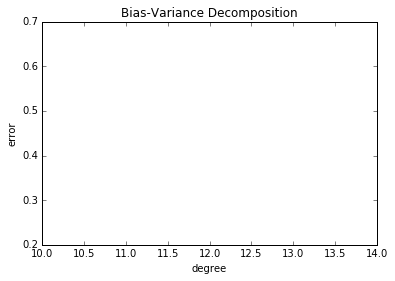

In [227]:
from plots import bias_variance_decomposition_visualization
bias_variance_decomposition_visualization(degrees, rmse_tr, rmse_te)

One can also do a loop over the cross_degrees indices, but it took too long, so we manually rerun the above and also estimated the testing error below.

# Estimate Testing Error

In [173]:
def get_fraction_correct(y, tx, w):
    return np.mean(y == np.sign(tx.dot(w)))

In [190]:
varianceToKeep = 0.99999
naCountPerColumn = np.sum(x_raw == -999, axis=0)
manyNaNsColumns = None#np.where(naCountPerColumn > 150000)

(tx, mean_x, std_x, toPCABasis_fcn) = clean_data_and_standardize(
    x_raw, varianceToKeep=varianceToKeep, toPCABasis_fcn=None, featuresToIgnore=manyNaNsColumns)

#bestDegree = 5
#bestLambda = 0.2395026619987486#10#0.5#0.02592943797404667

bestDegree = 5
bestLambda = 573.6152510448682

best_cross_features_degree = 3
bestDegree = 12
bestLambda = 10#1#0.1373823795883264

# for build_poly cross features
nbFeatures = tx.shape[1]
computeMaskForCrossFeatureDegree(best_cross_features_degree, nbFeatures)

compute_weightsFunction = exact_ridge_regression_least_squares
compute_lossFunction = compute_mse_loss
seed = 1
ratio_train = 0.05

(x_tr, y_tr, x_te, y_te) = split_data(tx, prediction, ratio_train, seed=seed)

# add polynomial features
x_poly_tr = build_poly(x_tr, bestDegree, best_cross_features_degree)
x_poly_te = build_poly(x_te, bestDegree, best_cross_features_degree)

# compute weights with ridge_regression on training set with given lambda (and degree)
weights_tr = compute_weightsFunction(y_tr, x_poly_tr, lamb = bestLambda)
# find the testing error
#mse_tr = compute_lossFunction(y_tr, x_poly_tr, weights_tr)
#mse_te = compute_lossFunction(y_te, x_poly_te, weights_tr)
#rmse_tr_val = np.sqrt(2*mse_tr)
#rmse_te_val = np.sqrt(2*mse_te)

#y_te_pred = predict_labels(weights_tr, x_te)

weights_real = weights_tr # used for real data

get_fraction_correct(y_tr, x_poly_tr, weights_tr)

0.83520000000000005

In [182]:
# Import data
filenameNew = 'test.csv'
prediction_wrong, x_real_raw, ids_real = load_csv_data(filenameNew, sub_sample=False)

Write in chunks to reduce load (avoid freezing of computer)

In [191]:


#tx_real, mean_x_wrong, std_x_wrong = clean_data_and_standardize(x_real_raw, mean_x=mean_x, std_x=std_x)
(tx_real, mean_x_wrong, std_x_wrong, toPCABasis_fcn_unused) = clean_data_and_standardize(
    x_real_raw, varianceToKeep=None, toPCABasis_fcn=toPCABasis_fcn, 
    featuresToIgnore = manyNaNsColumns, mean_x=mean_x, std_x=std_x)

#tx_real, mean_x_wrong, std_x_wrong = standardize(x_real_raw, mean_x=mean_x, std_x=std_x)

nbChunks = 20
nbRows = tx_real.shape[0]
nbRowsPerChunk = int(np.ceil(nbRows/nbChunks))
y_pred_global = np.array([])

for nbChunk in range(nbChunks):
    is_not_first_chunk = (nbChunk != 0)
    rangeStart = nbChunk * nbRowsPerChunk
    rangeEnd = (nbChunk + 1) * nbRowsPerChunk
    
    if rangeStart >= nbRows:
        break
    
    x_poly_real = build_poly(tx_real[rangeStart:rangeEnd], bestDegree, 
                             best_cross_features_degree) # this is safe if rangeEnd exceeds length

    y_pred = predict_labels(weights_real, x_poly_real)
    
    create_csv_submission(ids_real[rangeStart:rangeEnd], y_pred, 'submission.csv', append=is_not_first_chunk)

    y_pred_global = np.concatenate([y_pred_global, y_pred])
    print("Wrote chunk #{}/{}".format(nbChunk, nbChunks))

print("Wrote all")
print(sum(y_pred_global == 1) / len(y_pred_global))
print("To file: {} rows, expected: {} rows".format(len(y_pred_global), nbRows))

Wrote chunk #0/20
Wrote chunk #1/20
Wrote chunk #2/20
Wrote chunk #3/20
Wrote chunk #4/20
Wrote chunk #5/20
Wrote chunk #6/20
Wrote chunk #7/20
Wrote chunk #8/20
Wrote chunk #9/20
Wrote chunk #10/20
Wrote chunk #11/20
Wrote chunk #12/20
Wrote chunk #13/20
Wrote chunk #14/20
Wrote chunk #15/20
Wrote chunk #16/20
Wrote chunk #17/20
Wrote chunk #18/20
Wrote chunk #19/20
Wrote all
0.307140669931
To file: 568238 rows, expected: 568238 rows


In [262]:
nbRows

568238

In [27]:
! du -h submission.csv test.csv
#! cat submission.csv | head

5.9M	submission.csv
105M	test.csv
